# Otimização de Preços Utilizando Regressão
---

## Sumário

- [ 1 - Importações](#0)
- [ 2 - Descrição dos Dados](#1)
- [ 3 - Feature Engineering](#2)
- [ 4 - EDA](#3)
- [ 5 - Pré-Processamentos](#4)
- [ 6 - Machine Learning](#5)
- [ 7 - Previsão Teste](#6)
- [ 8 - Performance do Negócio](#7.0)
- [ 9 - Próximos Passos](#8.0)

<a name='0'></a>
# 0.0 Importações

In [4]:
import ast
import optuna
import inflection
import warnings

import pandas                                             as pd
import numpy                                              as np
import matplotlib.pyplot                                  as plt
import seaborn                                            as sns
import sklearn.cluster                                    as ct
import sklearn.metrics                                    as mt

from sklearn.preprocessing                                import TargetEncoder
from sklearn.model_selection                              import train_test_split

from sklearn.metrics                                      import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error 
from sklearn.ensemble                                     import RandomForestRegressor, VotingRegressor
from sklearn.linear_model                                 import LinearRegression
from xgboost                                              import XGBRegressor
from catboost                                             import CatBoostRegressor
from lightgbm                                             import LGBMRegressor

from scipy.stats                                          import chi2_contingency

plt.style.use('ggplot')
sns.set_style('darkgrid')

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

warnings.filterwarnings('ignore')

/home/aroldo/.pyenv/versions/3.11.4/envs/hackday_6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Funções Auxiliares

In [83]:
#Função para aplicar todas as limpezas nos dados de TESTE
def clean_test(X_test_2):
    X_test_2['product_details_count'] = X_test_2['product_details'].apply(lambda x: len(ast.literal_eval(x)) )
    X_test_2['product_details'] = X_test_2['product_details'].apply(lambda x: ast.literal_eval(x))

    all_keys = set()
    for data in X_test_2['product_details']:
        for item in data:
            all_keys.update(item.keys())
    
    for key in all_keys:
        X_test_2[key] = X_test_2['product_details'].apply(lambda x: next((item[key] for item in x if key in item), np.nan))
    
    X_test_2.drop('product_details', axis=1, inplace=True)

    X_test_2.rename(columns={'Pack of': 'Pack Of 2'}, inplace=True)
    
    X_test_2['Pack Of'].fillna(X_test_2['Pack Of 2'], inplace=True)
    
    X_test_2.drop('Pack Of 2', axis=1, inplace=True)

    details_to_maintain_test = ['pid', '_id',
                       'average_rating',
                       'number_of_reviews',
                       'brand',
                       'category',
                       'crawled_at',
                       'description',
                       'images',
                       'out_of_stock',
                       'avg_delivery_time_days',
                       'pid',
                       'seller',
                       'sub_category',
                       'fabrication_time',
                       'title',
                       'product_details_count',
                       "Fabric",
                        "Fabric Care",
                        "Hooded",
                        "Pockets",
                        "Pack Of",
                        "Secondary Color",
                        "Style Code",
                        "Ideal For",
                        "Reversible",
                        "Neck",
                        "Generic Name",
                        "Brand Fit",
                        "Pattern",
                        "Sleeve",
                        "Country of Origin",
                        "Size",
                        "Fit",
                        "Number of Contents in Sales Package",
                        "Suitable For",
                        "Occasion",
                        "Color",
                        "Neck Type",
                        'Type']
    X_test_2 = X_test_2[details_to_maintain_test]

    X_test_2['images'] = X_test_2['images'].apply(lambda x: ast.literal_eval(x))
    X_test_2['number_images'] = X_test_2['images'].apply(lambda x: len(x))

    #Coluna Fabric
    X_test_2['has_cotton']    = X_test_2['Fabric'].str.contains('cott', case=False, na=False)
    X_test_2['has_polyester'] = X_test_2['Fabric'].str.contains('poly', case=False, na=False)
    X_test_2['has_lycra']     = X_test_2['Fabric'].str.contains('lycr', case=False, na=False)
    
    #Coluna Brand Fit
    X_test_2['is_regular'] = X_test_2['Brand Fit'].str.contains('reg', case=False, na=False)
    X_test_2['is_slim']    = X_test_2['Brand Fit'].str.contains('slim', case=False, na=False)
    X_test_2['is_fit']     = X_test_2['Brand Fit'].str.contains('fit', case=False, na=False)

    cols_drop = ['_id','crawled_at','description','title','images']
    X_test_2 = X_test_2.drop(cols_drop, axis=1)

    X_test_2 = X_test_2.fillna(0)

    X_test_2.columns = X_test_2.columns.map(lambda x: inflection.parameterize(x, separator='_'))
    
    te_cols = ['brand','seller','sub_category',"fabric",
                        "fabric_care",
                        "hooded",
                        "pockets",
                        "pack_of",
                        "secondary_color",
                        "style_code",
                        "ideal_for",
                        "reversible",
                        "neck",
                        "generic_name",
                        "brand_fit",
                        "pattern",
                        "sleeve",
                        "country_of_origin",
                        "size",
                        "fit",
                        "number_of_contents_in_sales_package",
                        "suitable_for",
                        "occasion",
                        "color",
                        "neck_type",
                        "type"]
    
    X_test_2 = pd.get_dummies(X_test_2, columns=onehot)

    X_test_2.columns = X_test_2.columns.map(lambda x: inflection.parameterize(x, separator='_'))

    X_test_2[te_cols] = X_test_2[te_cols].astype(str)
    X_test_2[te_cols] = te.transform(X_test_2[te_cols])

    
    X_test_2 = X_test_2.drop(['pid'], axis=1).copy()

    return X_test_2

#Função Customizada da Métrica SMAPE
def smape(y_pred, y_test):

    smape = 100 / len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))
    return smape

#Função para computar todas as metricas
def compute_metrics(model_name, y_pred, y_test):

    y_pred = np.expm1(y_pred)
    y_test = np.expm1(y_test)
                     

    smape = 100 / len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))
    mae =mean_absolute_error(y_pred, y_test)
    mape = mean_absolute_percentage_error(y_pred, y_test)
    rmse = mean_squared_error(y_pred, y_test, squared=False)

    df = pd.DataFrame({
        'Model':model_name,
        'MAE':mae,
        'MAPE':mape,
        'RMSE':rmse,
        'SMAPE':smape
    }, index=[0])

    return df

#Função para montar a submissão
def make_submission(X_test_2, y_pred_test):
    
    test_raw = pd.read_json( 'test.json', orient='split')
    X_test_submission = X_test_2.copy()
    X_test_submission['pid'] = test_raw['pid']
    X_test_submission['actual_price'] = y_pred_test
    df_submission = X_test_submission[['pid','actual_price']]

    return df_submission

#Função para analisar Correlação de categóricas
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

## Carregar Dados

In [6]:
df_raw = pd.read_json( 'train.json', orient='split')

<a name='1'></a>
# 1.0 Descrição dos Dados

In [7]:
df_raw.head(3)

,_id,average_rating,number_of_reviews,brand,category,crawled_at,description,images,out_of_stock,avg_delivery_time_days,pid,product_details,seller,sub_category,fabrication_time,title,actual_price
0,53df9662-e500-569c-946e-0c8d215a72cd,3.2,26,East I,Clothing and Accessories,2021-02-10 21:17:28,Navy Blue Printed Boxers Has An Inner Elasti...,['https://rukminim1.flixcart.com/image/128/128...,False,8,BXRFTZF7JGX75DAW,"[{'Color': 'Dark Blue'}, {'Fabric': 'Pure Cott...",ZIYAA,Innerwear and Swimwear,653,Printed Men Boxer (Pack of 1),849.0
1,d0142842-84f7-537d-a06f-d85b76488a5f,4.0,33,dream o,Clothing and Accessories,2021-02-11 01:02:46,smiley printed tshirt on round neck cotton tshirt,['https://rukminim1.flixcart.com/image/128/128...,False,12,TSHFWQM96UHR6A4Q,"[{'Type': 'Round Neck'}, {'Sleeve': 'Short Sle...",Dream Onn Creations,Topwear,668,Printed Men Round Neck Orange T-Shirt,699.0
2,79c8f0d7-30b1-5dd4-9f2f-2fe97782b027,3.9,32,Free Authori,Clothing and Accessories,2021-02-11 00:43:37,Free Authority Presents this Crew Neck Yellow ...,['https://rukminim1.flixcart.com/image/128/128...,False,11,SWSFWCXH2WF6ZYRB,"[{'Color': 'Yellow'}, {'Fabric': 'Polycotton'}...",BioworldMerchandising,Winter Wear,53,Full Sleeve Graphic Print Men Sweatshirt,1499.0


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23309 entries, 0 to 23308
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   _id                     23309 non-null  object        
 1   average_rating          23309 non-null  float64       
 2   number_of_reviews       23309 non-null  int64         
 3   brand                   23309 non-null  object        
 4   category                23309 non-null  object        
 5   crawled_at              23309 non-null  datetime64[ns]
 6   description             23309 non-null  object        
 7   images                  23309 non-null  object        
 8   out_of_stock            23309 non-null  bool          
 9   avg_delivery_time_days  23309 non-null  int64         
 10  pid                     23309 non-null  object        
 11  product_details         23309 non-null  object        
 12  seller                  23309 non-null  object     

In [9]:
df_raw.describe()

,average_rating,number_of_reviews,crawled_at,avg_delivery_time_days,fabrication_time,actual_price
count,23309.000000,23309.000000,23309,23309.000000,23309.000000,19813.000000
mean,3.367322,27.767386,2021-02-10 22:55:49.561242624,9.933502,366.663563,1480.980568
min,0.000000,0.000000,2021-02-10 20:11:51,3.000000,1.000000,150.000000
25%,3.100000,26.000000,2021-02-10 21:30:50,7.000000,184.000000,895.000000
50%,3.700000,31.000000,2021-02-10 23:01:37,10.000000,369.000000,1256.000000
75%,4.100000,34.000000,2021-02-11 00:17:54,13.000000,550.000000,1799.000000
max,5.000000,41.000000,2021-02-11 01:31:55,19.000000,729.000000,12999.000000
std,1.157570,9.555809,NaN,3.568971,210.255811,967.824650


In [10]:
df_raw.nunique()

_id                       23309
average_rating               39
number_of_reviews            33
brand                       307
category                      4
crawled_at                15293
description                4318
images                    19089
out_of_stock                  2
avg_delivery_time_days       17
pid                       21951
product_details           20955
seller                      483
sub_category                 24
fabrication_time            729
title                      3973
actual_price                636
dtype: int64

<a name='2'></a>
# 2.0 Feature Engineering

In [11]:
df1 = df_raw.copy()

## 2.1 Coluna Product Details

### Contar Número de Produtos

In [12]:
#Usar a função ast.literal_eval() para transformar expressões literais em dicionários
df1['product_details_count'] = df1['product_details'].apply(lambda x: len(ast.literal_eval(x)) )

### Transformar detalhes dos produtos em colunas

In [13]:
#Usar a função ast.literal_eval() para transformar expressões literais em dicionários
df1['product_details'] = df1['product_details'].apply(lambda x: ast.literal_eval(x))

In [14]:
#Buscar por todas as chaves dos dicionários
all_keys = set()
for data in df1['product_details']:
    for item in data:
        all_keys.update(item.keys())

#Para cada chave,crie uma coluna no dataframe e verifique, linha por linha, se essa coluna está presente na chave da dicionário, caso esteja insira o valor da chave, senão coloque NAN
for key in all_keys:
    df1[key] = df1['product_details'].apply(lambda x: next((item[key] for item in x if key in item), np.nan))
    
#Drope a coluna usada
df1.drop('product_details', axis=1, inplace=True)

In [15]:
#Renomear colunas duplicadas
df1.rename(columns={'Pack of': 'Pack Of 2'}, inplace=True)

df1['Pack Of'].fillna(df1['Pack Of 2'], inplace=True)

df1.drop('Pack Of 2', axis=1, inplace=True)

In [16]:
df1.head(2)

,_id,average_rating,number_of_reviews,brand,category,crawled_at,description,images,out_of_stock,avg_delivery_time_days,pid,seller,sub_category,fabrication_time,title,actual_price,product_details_count,,Domestic Warranty,Coat Type,Width,Model Number,Tanning Process,Tip Shape,Character,Series,Other Features,Alteration Required,Waist in inch,Technology Used,Collar,Hem,Brand,Waistband,Shoulder in inch,Hip in inch,Lining Material,Fabric care,Upper Pattern,Bust in inch,Placket,Type for Flats,Sales Package,Pleats,Neck,Fly,Suitable For,Ideal For,Covered in Warranty,Foot Coverage,Width in inch,School Shoe,Thumb Hole,Care Instructions,Pockets,Distressed,Style,Width at Base,Weave type,Top Type,Belt Loops,Package contains,Warranty Service Type,Bottom Length,International Warranty,Pack Of,Care instructions,Weight,Heel Pattern,Color,Stitching Type,Clasp Material,Leather Type,Fastener,Country of Origin,Occasion,Shoe Length,Not Covered in Warranty,Animal Source,Generic Name,Sleeve Type,Pocket Type,Inner Material,Length in inch,Season,Brand Fit,Warranty Summary,Fit,Lining,Number of Contents in Sales Package,Faded,Top Closure,Inside Leg in inch,Maximum Age,Sleeve in inch,,Other Details,Rise,Design,Strap Material,Dupatta Length,Minimum Age,Sleeve,Fabric,Cuff,Model Name,Pleated,Vents,Other Dimensions,Model Details,Hooded,Type,Inseam Length,Length,Pattern,Style Code,Secondary Color,Knit Type,Closure,Top Length,Stretchable,Weave Type,Outer Material,Fabric Details,Material,Fabric Care,Length Type,Height,Rise in inch,Bottom Type,Top Fabric,Region,Brand Color,Reversible,Clasp Type,Size,Neck Type,Thigh in inch,Bottom Fabric,Shade,Sole Material
0,53df9662-e500-569c-946e-0c8d215a72cd,3.2,26,East I,Clothing and Accessories,2021-02-10 21:17:28,Navy Blue Printed Boxers Has An Inner Elasti...,['https://rukminim1.flixcart.com/image/128/128...,False,8,BXRFTZF7JGX75DAW,ZIYAA,Innerwear and Swimwear,653,Printed Men Boxer (Pack of 1),849.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 boxer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,Dark Blue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pure Cotton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Printed,EIBXCO053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,d0142842-84f7-537d-a06f-d85b76488a5f,4.0,33,dream o,Clothing and Accessories,2021-02-11 01:02:46,smiley printed tshirt on round neck cotton tshirt,['https://rukminim1.flixcart.com/image/128/128...,False,12,TSHFWQM96UHR6A4Q,Dream Onn Creations,Topwear,668,Printed Men Round Neck Orange T-Shirt,699.0,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pack of 1,NaN,NaN,NaN,Western Wear,Men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Narrow,NaN,NaN,NaN,NaN,NaN,NaN,Regular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Short Sleeve,Cotton Blend,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Round Neck,NaN,NaN,Printed,orange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Do not Iron on print/embroidery/embellishment,NaN,NaN,NaN,NaN,NaN,NaN,ORANGE,No,NaN,M,Round Neck,NaN,NaN,NaN,NaN


In [17]:
df1.shape

(23309, 141)

### Selecionar As Melhores Colunas

In [18]:
df1.isna().sum()

_id                                        0
average_rating                             0
number_of_reviews                          0
brand                                      0
category                                   0
crawled_at                                 0
description                                0
images                                     0
out_of_stock                               0
avg_delivery_time_days                     0
pid                                        0
seller                                     0
sub_category                               0
fabrication_time                           0
title                                      0
actual_price                            3496
product_details_count                      0
                                       23073
Domestic Warranty                      22575
Coat Type                              23305
Width                                  23306
Model Number                           23252
Tanning Pr

In [19]:
#Utilizar apenas colunas abaixo de 20.000 NaNs
count_nan = pd.DataFrame(df1.isna().sum()).rename(columns={0:'Numero NaN'})
count_nan.loc[count_nan['Numero NaN'] < 20000,:]

,Numero NaN
_id,0
average_rating,0
number_of_reviews,0
brand,0
category,0
crawled_at,0
description,0
images,0
out_of_stock,0
avg_delivery_time_days,0


In [20]:
details_to_maintain = ['pid', '_id',
                       'average_rating',
                       'number_of_reviews',
                       'brand',
                       'category',
                       'crawled_at',
                       'description',
                       'images',
                       'out_of_stock',
                       'avg_delivery_time_days',
                       'seller',
                       'sub_category',
                       'fabrication_time',
                       'title',
                       'actual_price',
                       'product_details_count',
                       "Fabric",
                        "Fabric Care",
                        "Hooded",
                        "Pockets",
                        "Pack Of",
                        "Secondary Color",
                        "Style Code",
                        "Ideal For",
                        "Reversible",
                        "Neck",
                        "Generic Name",
                        "Brand Fit",
                        "Pattern",
                        "Sleeve",
                        "Country of Origin",
                        "Size",
                        "Fit",
                        "Number of Contents in Sales Package",
                        "Suitable For",
                        "Occasion",
                        "Color",
                        "Neck Type",
                        "Type"]


df1 = df1[details_to_maintain]

In [21]:
df1.shape

(23309, 40)

## 2.2 Criar colunas Numero de Imagens

In [22]:
#Coluna images
df1['images'] = df1['images'].apply(lambda x: ast.literal_eval(x))
df1['number_images'] = df1['images'].apply(lambda x: len(x))
df1 = df1.drop(['images'],axis=1)

## 2.3 Criar Colunas Baseado nos Tecidos e no Tamanho

In [23]:
#Coluna Fabric
df1['has_cotton']    = df1['Fabric'].str.contains('cott', case=False, na=False)
df1['has_polyester'] = df1['Fabric'].str.contains('poly', case=False, na=False)
df1['has_lycra']     = df1['Fabric'].str.contains('lycr', case=False, na=False)

#Coluna Brand Fit
df1['is_regular'] = df1['Brand Fit'].str.contains('reg', case=False, na=False)
df1['is_slim']    = df1['Brand Fit'].str.contains('slim', case=False, na=False)
df1['is_fit']     = df1['Brand Fit'].str.contains('fit', case=False, na=False)

## 2.4 Preencher NaNs

In [24]:
df1 = df1.dropna(subset='actual_price')

In [25]:
df1 = df1.fillna(0)

In [26]:
df1.isna().sum()

pid                                    0
_id                                    0
average_rating                         0
number_of_reviews                      0
brand                                  0
category                               0
crawled_at                             0
description                            0
out_of_stock                           0
avg_delivery_time_days                 0
seller                                 0
sub_category                           0
fabrication_time                       0
title                                  0
actual_price                           0
product_details_count                  0
Fabric                                 0
Fabric Care                            0
Hooded                                 0
Pockets                                0
Pack Of                                0
Secondary Color                        0
Style Code                             0
Ideal For                              0
Reversible      

In [27]:
df1.nunique()

pid                                    18718
_id                                    19813
average_rating                            38
number_of_reviews                         32
brand                                    301
category                                   3
crawled_at                             13940
description                             3903
out_of_stock                               2
avg_delivery_time_days                    17
seller                                   460
sub_category                              23
fabrication_time                         729
title                                   3580
actual_price                             636
product_details_count                     25
Fabric                                   198
Fabric Care                              422
Hooded                                     3
Pockets                                   98
Pack Of                                   14
Secondary Color                           51
Style Code

In [28]:
df1.shape

(19813, 46)

<a name='3'></a>
# 3.0 EDA

## 3.1 Analise Univariada

In [29]:
#Separar dataframes em numerico e categorico
numerical_feat = df1.select_dtypes(include=['float','int'])
categorical_feat = df1.select_dtypes(exclude=['float','int','datetime'])

array([[<Axes: title={'center': 'average_rating'}>,
        <Axes: title={'center': 'number_of_reviews'}>,
        <Axes: title={'center': 'avg_delivery_time_days'}>],
       [<Axes: title={'center': 'fabrication_time'}>,
        <Axes: title={'center': 'actual_price'}>,
        <Axes: title={'center': 'product_details_count'}>],
       [<Axes: title={'center': 'number_images'}>, <Axes: >, <Axes: >]],
      dtype=object)

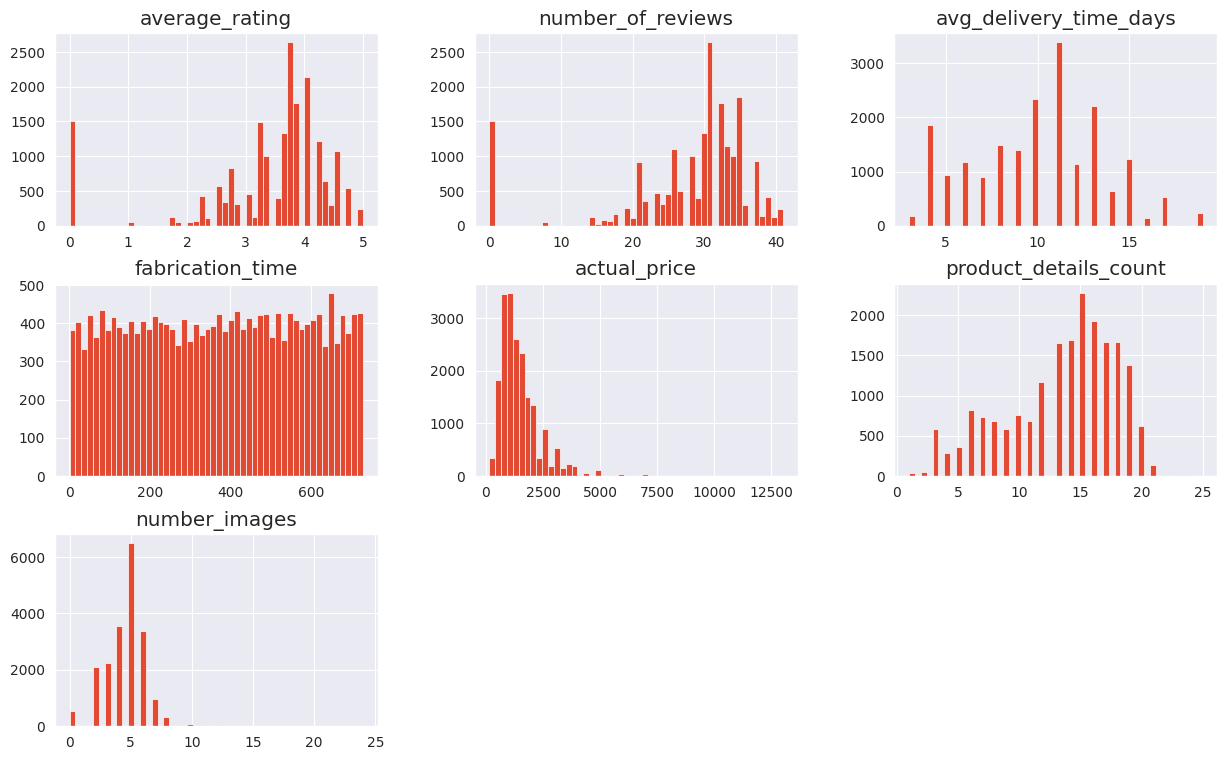

In [30]:
numerical_feat.hist(bins=50, figsize=(15,9))

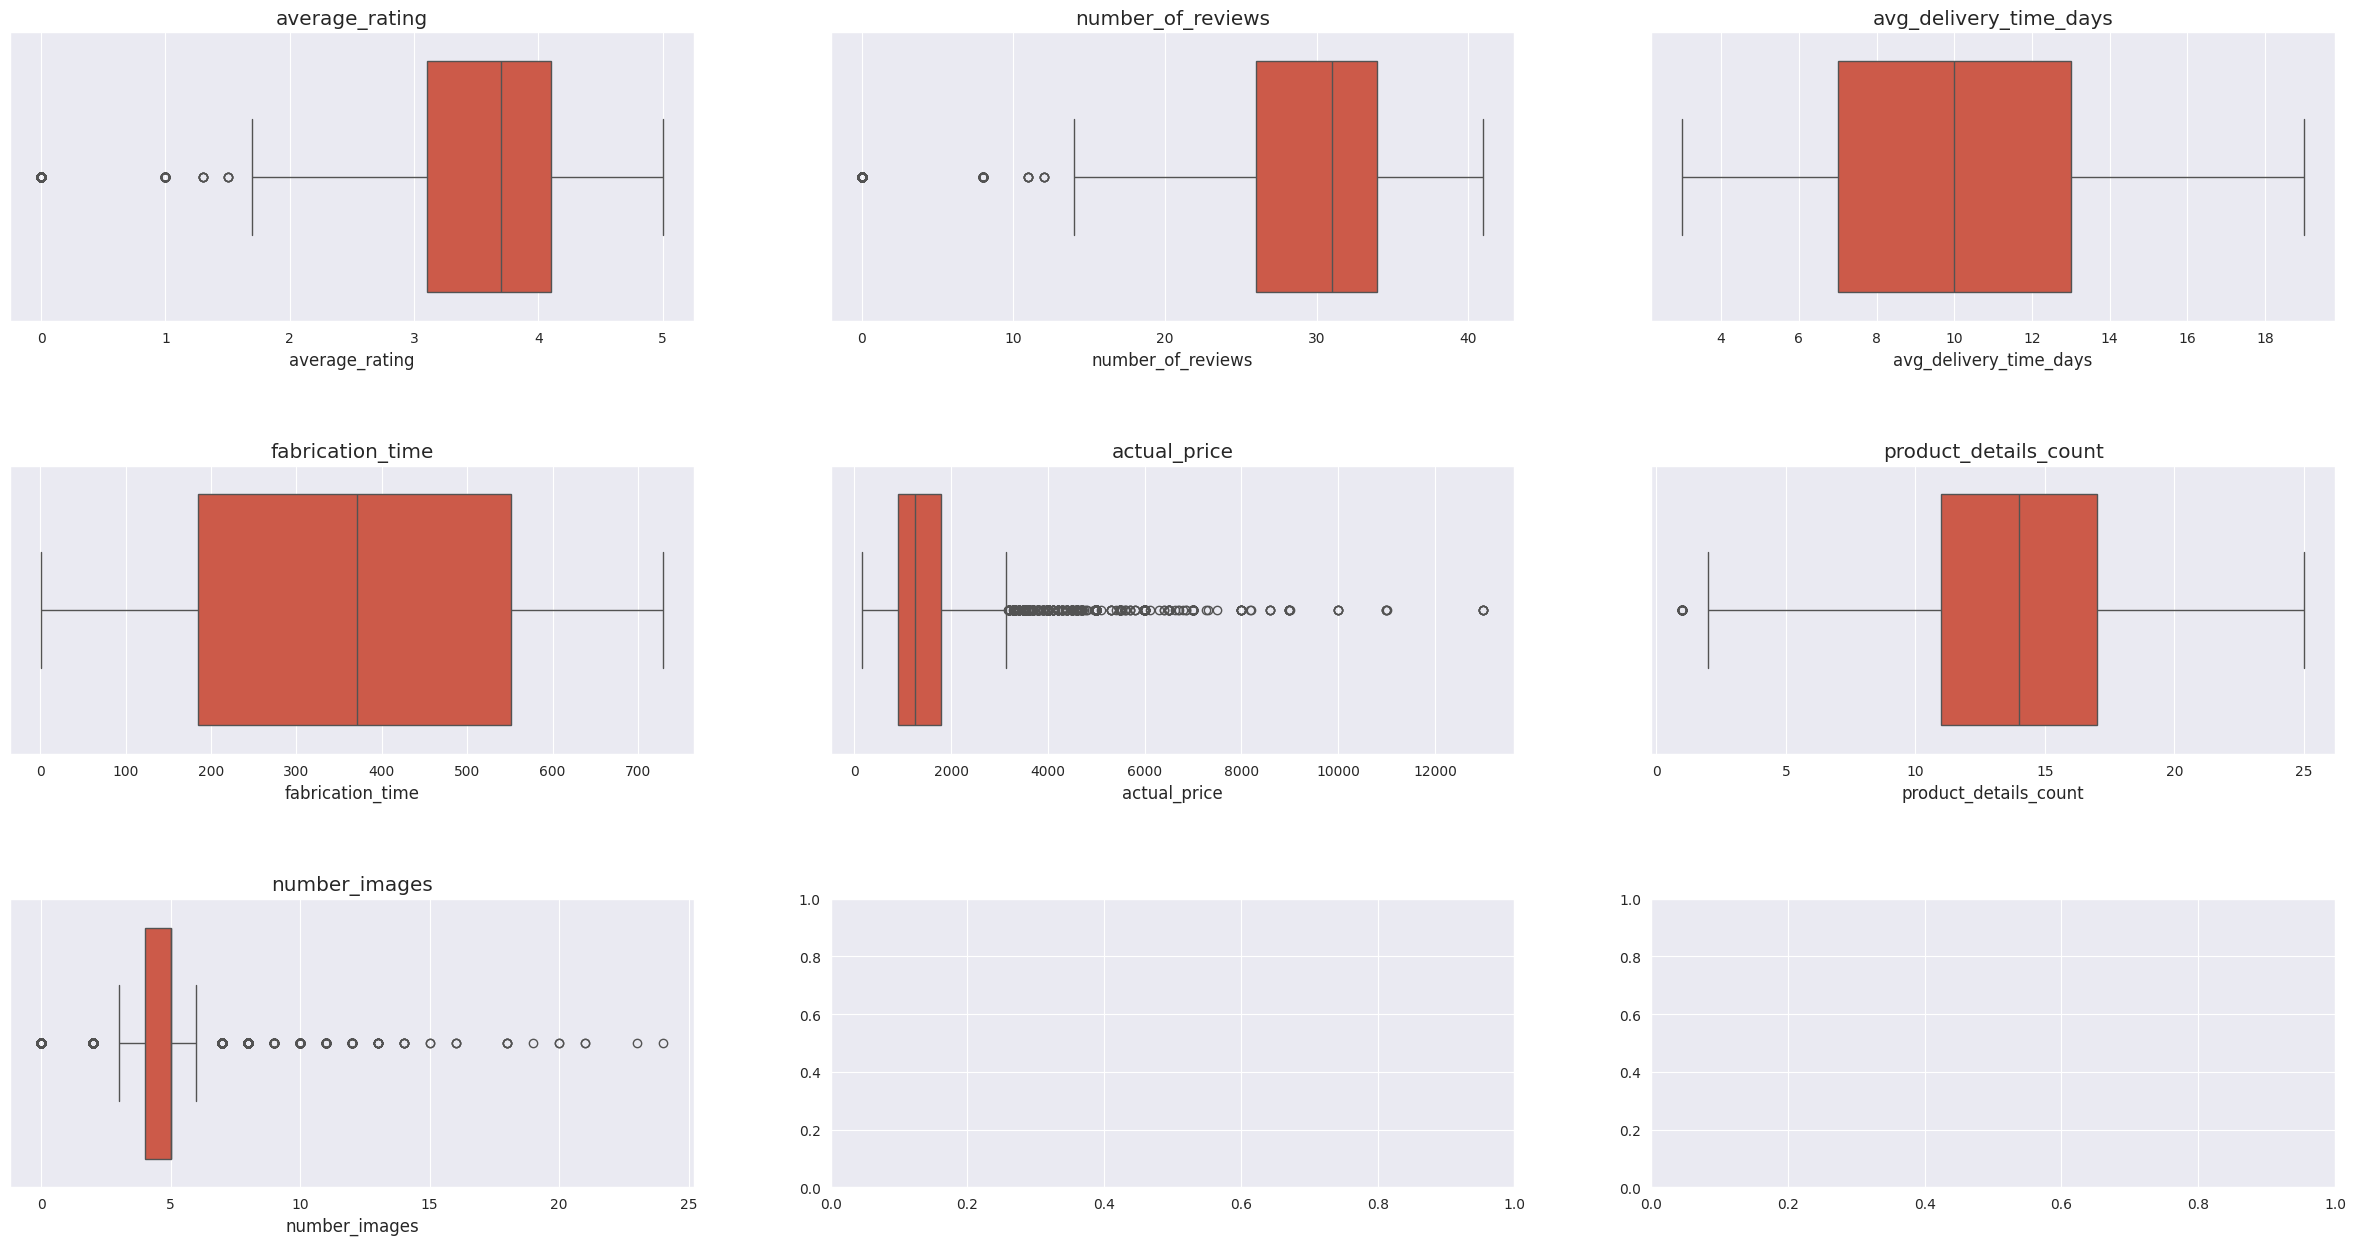

In [31]:
columns_to_plot = numerical_feat.columns

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
fig.subplots_adjust(hspace=0.5)

#Usar o divmod para encontrar os axes 
for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    #plotar todos os boxplots
    sns.boxplot(df1, x=column, ax=ax)
    ax.set_title(column)

plt.show()

## 3.2 Analise Bivariada

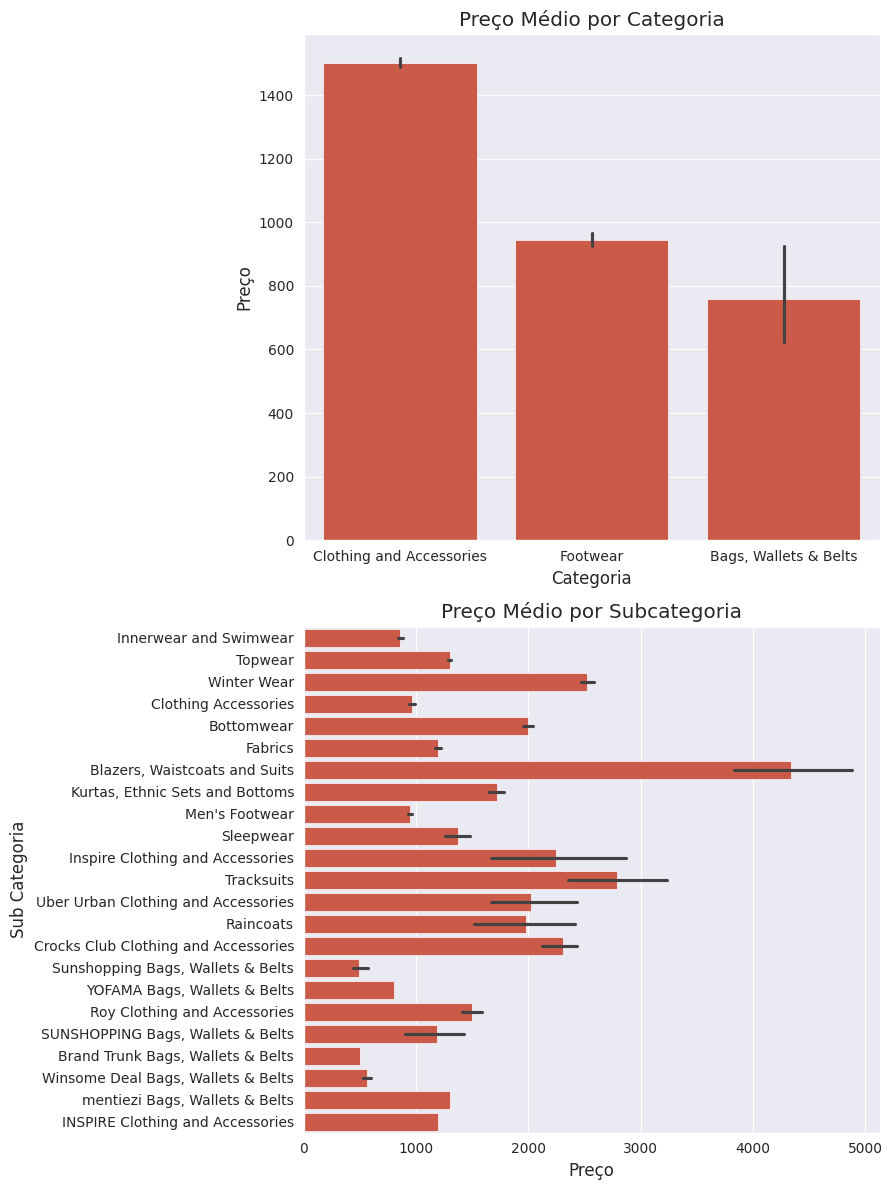

In [32]:
plt.figure(figsize=(9,12))

#Category
plt.subplot(2,1,1)
sns.barplot(df1, x='category', y='actual_price')
plt.title('Preço Médio por Categoria')
plt.xlabel("Categoria")
plt.ylabel("Preço")

#Subcategory
plt.subplot(2,1,2)
sns.barplot(df1, x='actual_price', y='sub_category', orient='horizontal')
plt.title('Preço Médio por Subcategoria')
plt.xlabel("Preço")
plt.ylabel("Sub Categoria")


plt.tight_layout()

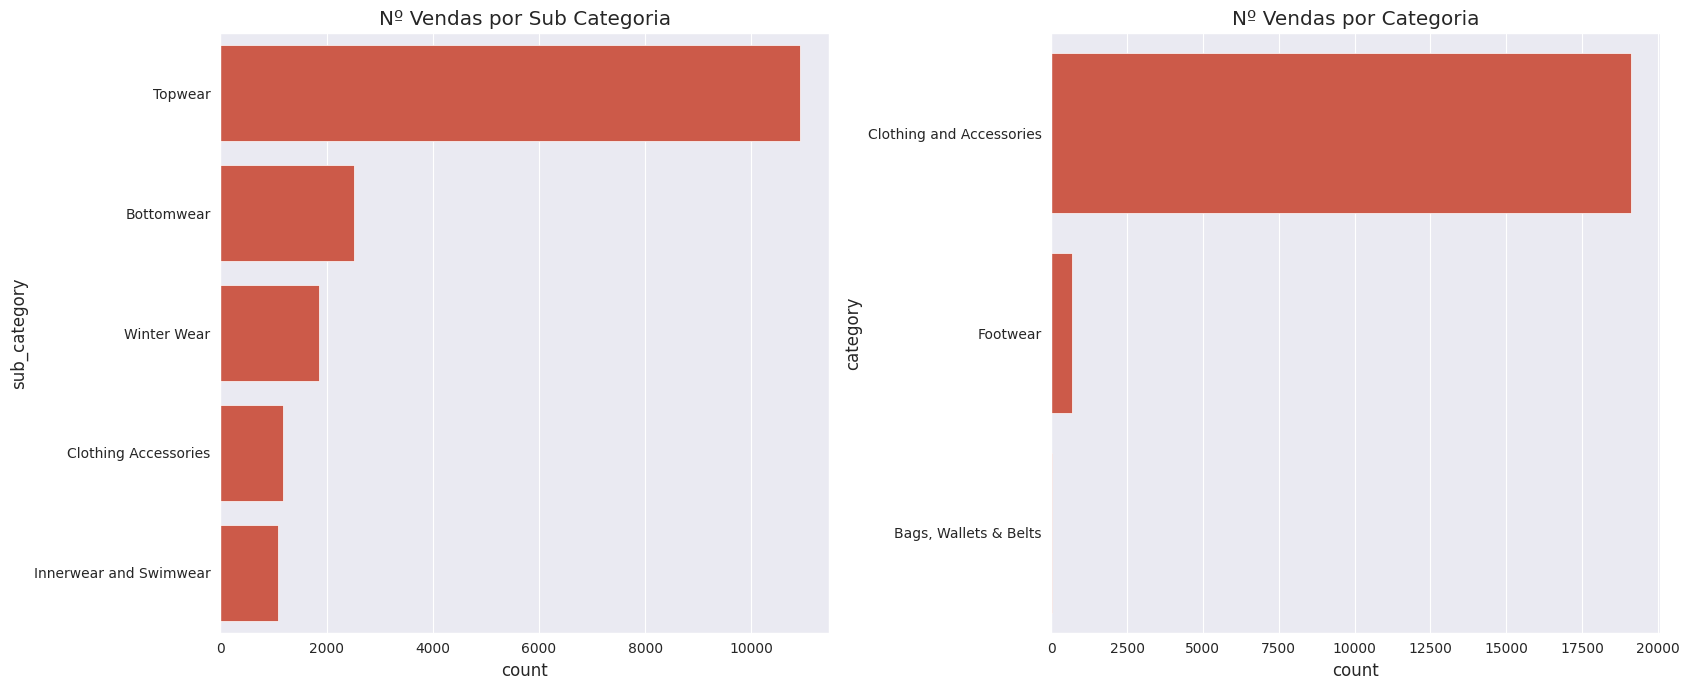

In [33]:
plt.figure(figsize=(17,7))

#Sub Category vendas
plt.subplot(1,2,1)
top5_subcat = df1['sub_category'].value_counts().iloc[:5]
top5_subcat = pd.DataFrame(top5_subcat)
sns.barplot(top5_subcat,x='count', y='sub_category', orient='horizontal')
plt.title("Nº Vendas por Sub Categoria")

#Category Vendas
plt.subplot(1,2,2)
top3_cat = df1['category'].value_counts()
top3_cat = pd.DataFrame(top3_cat)
sns.barplot(top3_cat, x='count', y='category', orient='horizontal')
plt.title("Nº Vendas por Categoria")

plt.tight_layout()

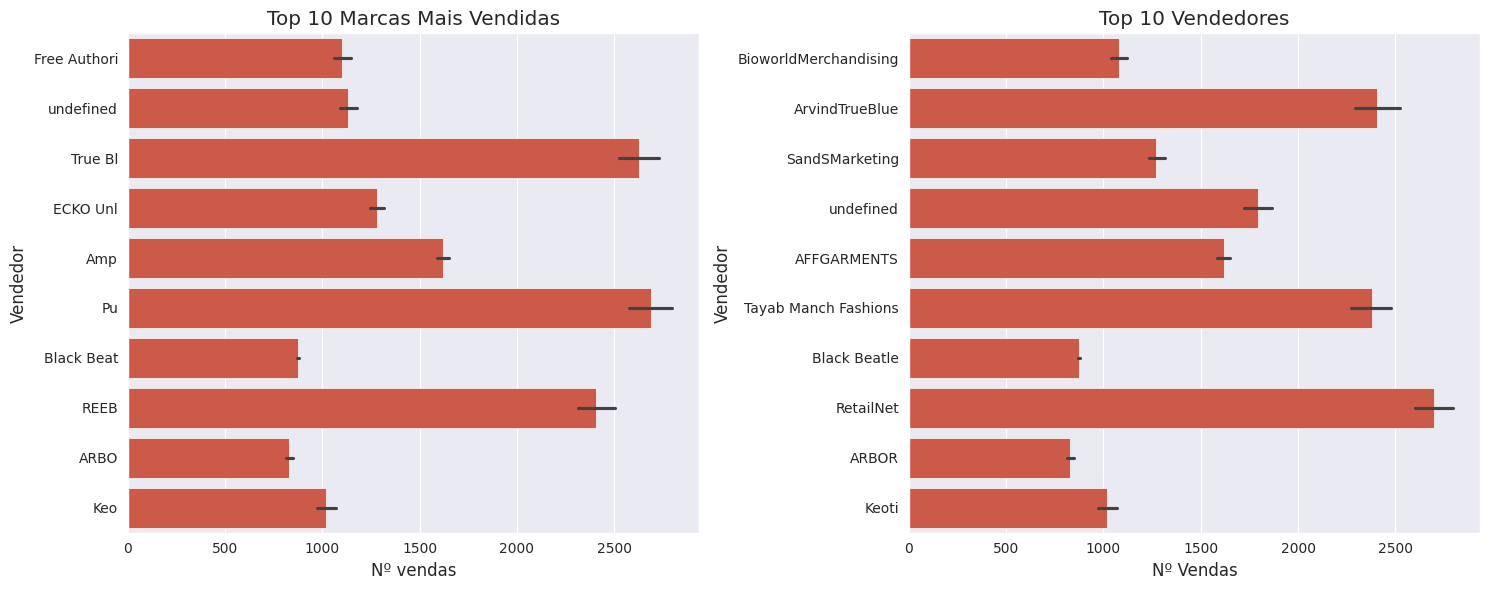

In [34]:
plt.figure(figsize=(15,6))

#top 10 Brands
plt.subplot(1,2,1)
top10_brands = df1['brand'].value_counts().iloc[:10].index
top_df = df1.loc[df1['brand'].isin(top10_brands),:]
sns.barplot(top_df, y='brand', x='actual_price', orient='horizontal')
plt.title("Top 10 Marcas Mais Vendidas")
plt.xlabel("Nº vendas")
plt.ylabel("Vendedor")

#top 10 Sellers
plt.subplot(1,2,2)
top10_seller = df1['seller'].value_counts().iloc[:10].index
top_df_seller = df1.loc[df1['seller'].isin(top10_seller),:]
sns.barplot(top_df_seller, y='seller', x='actual_price', orient='horizontal')
plt.title("Top 10 Vendedores")
plt.xlabel("Nº Vendas")
plt.ylabel("Vendedor")

plt.tight_layout()

<Axes: xlabel='is_fit', ylabel='actual_price'>

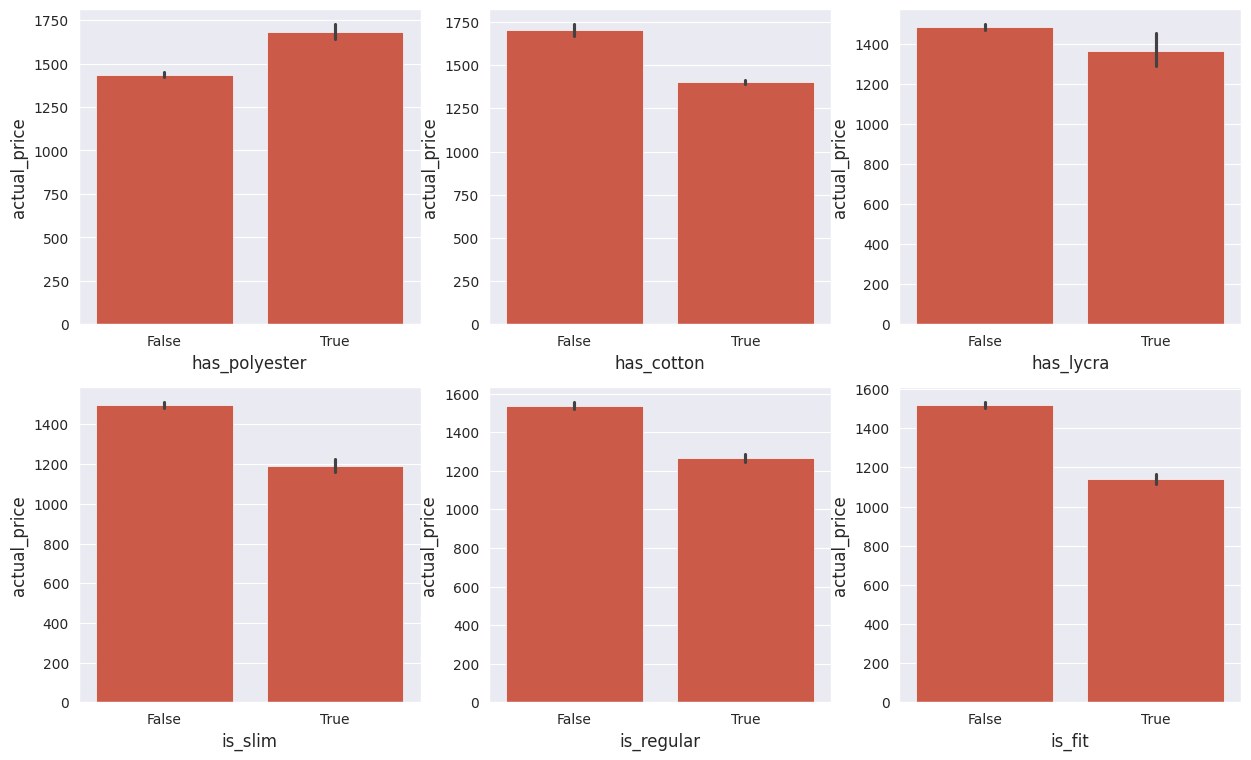

In [35]:
plt.figure(figsize=(15,9))

#Plotor todos os tipos de tecidos e Sizes
plt.subplot(2,3,1)
sns.barplot(df1, y='actual_price', x='has_polyester')

plt.subplot(2,3,2)
sns.barplot(df1, y='actual_price', x='has_cotton')

plt.subplot(2,3,3)
sns.barplot(df1, y='actual_price', x='has_lycra')

plt.subplot(2,3,4)
sns.barplot(df1, y='actual_price', x='is_slim')

plt.subplot(2,3,5)
sns.barplot(df1, y='actual_price', x='is_regular')

plt.subplot(2,3,6)
sns.barplot(df1, y='actual_price', x='is_fit')

Text(0, 0.5, 'País de Origem')

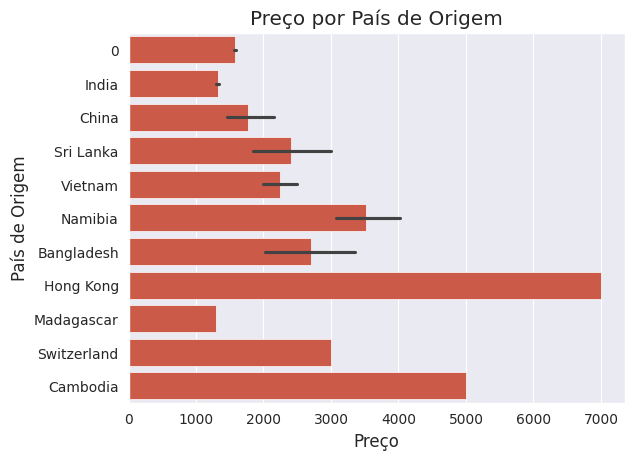

In [36]:
#Origem de fabricação da roupa
sns.barplot(df1, y='Country of Origin', x='actual_price', orient='horizontal')
plt.title("Preço por País de Origem")
plt.xlabel("Preço")
plt.ylabel("País de Origem")


## 3.3 Análise Multivariada

Text(0.5, 1.0, 'Matriz de Correlação Variáveis Numéricas')

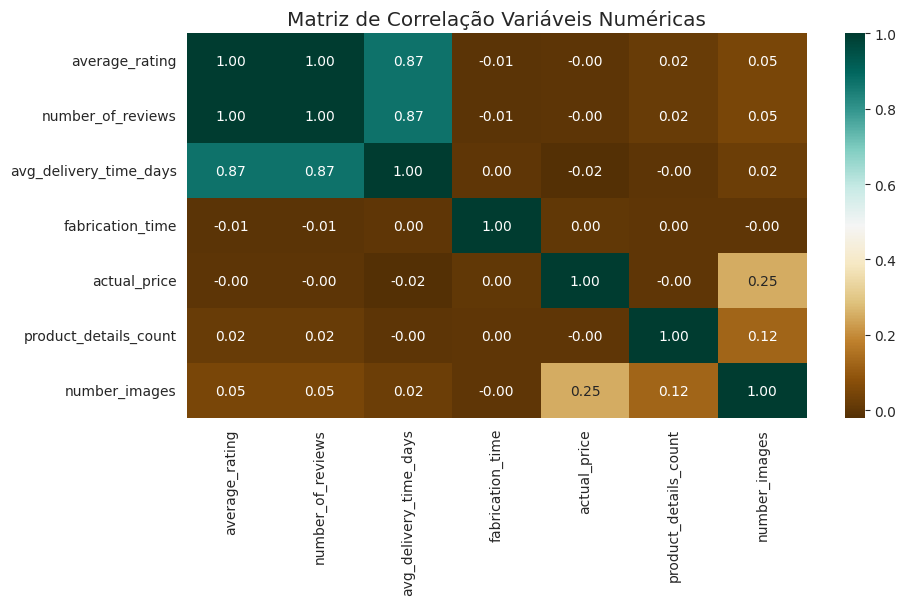

In [37]:
#Correlação Numéricas
plt.figure(figsize=(10,5))
sns.heatmap(numerical_feat.corr(), annot=True, fmt='.2f', cmap='BrBG')
plt.title("Matriz de Correlação Variáveis Numéricas")

In [38]:
#Selecionar categóricas para usar no função CRAMER'S V
df_cramer = df1.loc[:,['brand',
                       'category',
                       'sub_category',
                       'actual_price', 
                       'Type',
                       'seller',
                       'Fabric Care', 
                       'Style Code']]

num_vars = len(df_cramer.columns)
correlation_matrix = np.zeros((num_vars, num_vars))

In [39]:
#Aplicar o Cramer's V para criar matriz de correlação
for i in range(num_vars):
    for j in range(num_vars):
        if i != j:
            corr = cramers_v(df_cramer.iloc[:, i], df_cramer.iloc[:, j])
            correlation_matrix[i, j] = corr

Text(0.5, 1.0, 'Correlação Variáveis Categóricas')

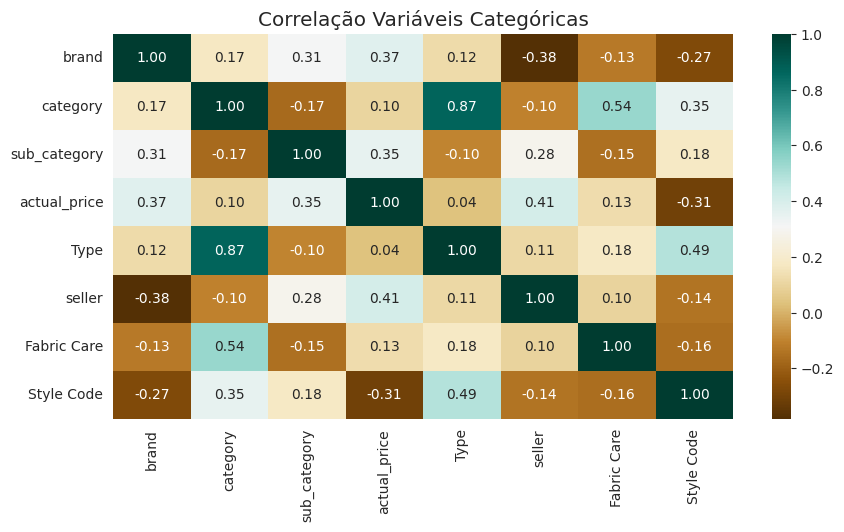

In [40]:
plt.figure(figsize=(10,5))

correlation_df = pd.DataFrame(correlation_matrix, columns=df_cramer.columns, index=df_cramer.columns)
sns.heatmap(correlation_df.corr(), annot=True, fmt='.2f', cmap='BrBG')
plt.title("Correlação Variáveis Categóricas")

## 3.4 Hipóteses

### Relação entre Média de Avaliação e Preço

H1 - Produtos com um maior número de avaliações têm mais vendas e, portanto, preços mais elevados.

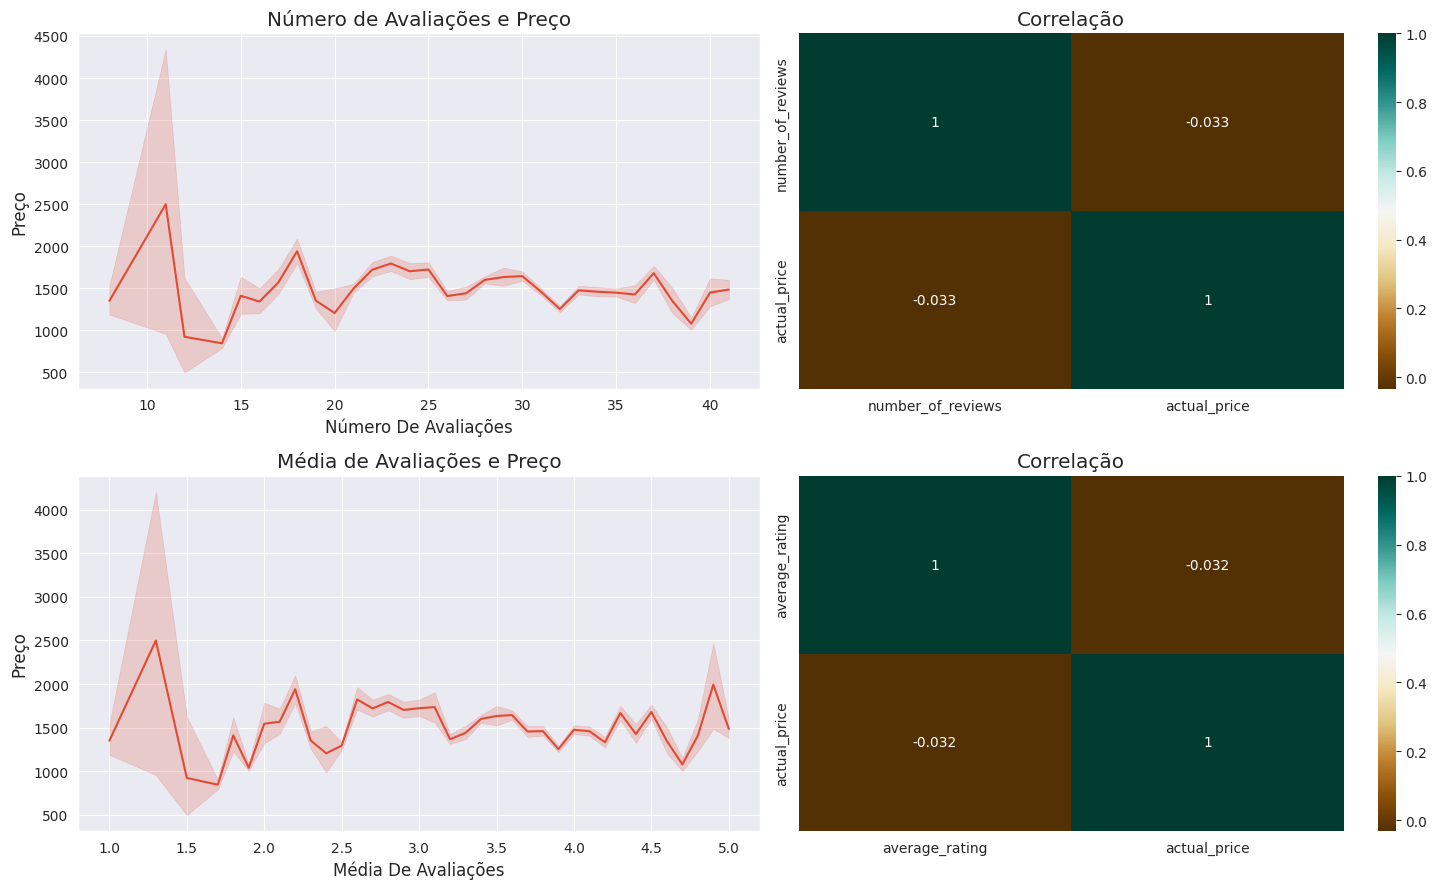

In [41]:
plt.figure(figsize=(15, 9))  

#Number of Reviews
plt.subplot(2, 2, 1) 
sns.lineplot(data=df1.loc[df1['number_of_reviews'] > 0,:], x='number_of_reviews', y='actual_price')
plt.title('Número de Avaliações e Preço')
plt.xlabel("Número De Avaliações")
plt.ylabel("Preço")

plt.subplot(2, 2, 2)  
sns.heatmap(df1.loc[df1['number_of_reviews'] > 0,['number_of_reviews', 'actual_price']].corr(), annot=True, cmap='BrBG')
plt.title('Correlação')

#--------------------------------------------------------------#

#Average Rating
plt.subplot(2, 2, 3) 
sns.lineplot(data=df1.loc[df1['average_rating'] > 0,:], x='average_rating', y='actual_price')
plt.title('Média de Avaliações e Preço')
plt.xlabel("Média De Avaliações")
plt.ylabel("Preço")



plt.subplot(2, 2, 4)  
sns.heatmap(df1.loc[df1['average_rating'] > 0,['average_rating', 'actual_price']].corr(), annot=True, cmap='BrBG')
plt.title('Correlação')

plt.tight_layout()

FALSO. Não temos uma correlação entre Avaliações e Preço.

### Relação entre Descrição e Preço

H2 - Produtos com mais Imagens e detalhes podem ter um preço mais elevado ou vender mais.

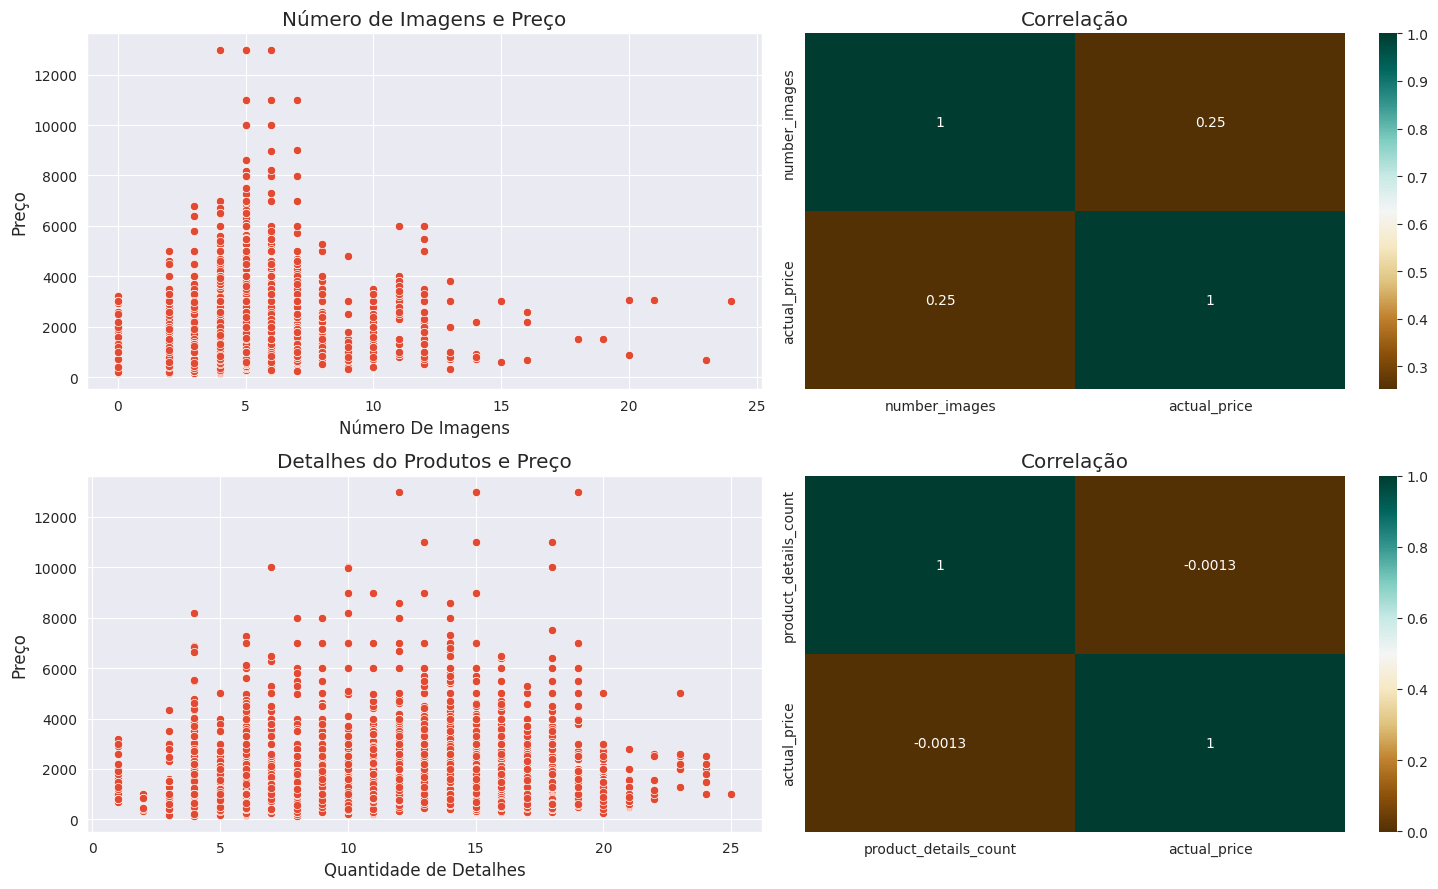

In [42]:
plt.figure(figsize=(15, 9))  

#Number Images
plt.subplot(2, 2, 1) 
sns.scatterplot(data=df1, x='number_images', y='actual_price')
plt.title('Número de Imagens e Preço')
plt.xlabel("Número De Imagens")
plt.ylabel("Preço")

plt.subplot(2, 2, 2)  
sns.heatmap(df1[['number_images', 'actual_price']].corr(), annot=True, cmap='BrBG')
plt.title('Correlação')

#-----------------------------------------------------#

#Product Details Count
plt.subplot(2, 2, 3) 
sns.scatterplot(data=df1, x='product_details_count', y='actual_price')
plt.title('Detalhes do Produtos e Preço')
plt.xlabel("Quantidade de Detalhes")
plt.ylabel("Preço")

plt.subplot(2, 2, 4)  
sns.heatmap(df1[['product_details_count', 'actual_price']].corr(), annot=True, cmap='BrBG')
plt.title('Correlação')

plt.tight_layout()

VERDADEIRO. Temos uma Correlação positiva entre número imagens e o preço, indicadando que itens com preços elevados tendem a ter mais fotos e, consequentemente venderem mais.

### Relação entre Estoque e Preço

H3 - Produtos que estão fora de estoque podem ser precificados de forma diferente.

Text(0, 0.5, 'Preço')

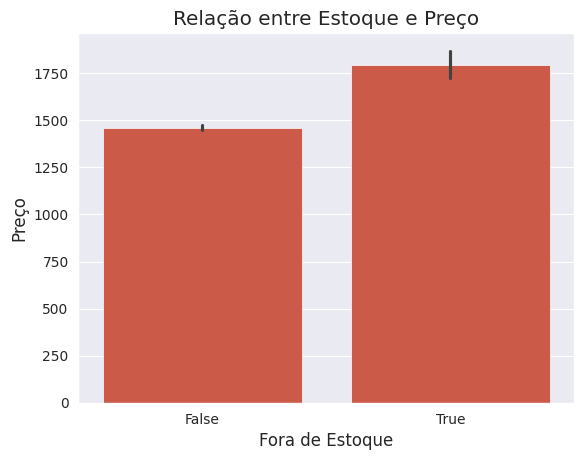

In [43]:
sns.barplot(df1, x='out_of_stock', y='actual_price')
plt.title("Relação entre Estoque e Preço")
plt.xlabel("Fora de Estoque")
plt.ylabel("Preço")

VERDADEIRO. Vemos um ligeira diferença entre Produtos em estoque e sem. Pode ser uma estrategia da empresa aumentar os preços de produtos fora de estoque até esse estoque ser renovado.

## Filtrar Colunas

In [44]:
cols_drop = ['_id','crawled_at','description','title']
df1 = df1.drop(cols_drop, axis=1)

#aplicar inflection para renomear colunas
df1.columns = df1.columns.map(lambda x: inflection.parameterize(x, separator='_'))

<a name='4'></a>
# 4.0 Pré-Processamentos

In [45]:
X = df1.drop(['pid','actual_price'], axis=1).copy()
y = df1['actual_price'].copy()

In [46]:
#20% validação e 80% treino
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.1 One-Hot Encoding

In [47]:
#One Hot Encoding
onehot = ['category','out_of_stock']
X_train = pd.get_dummies(X_train, columns=onehot)
X_val = pd.get_dummies(X_val, columns=onehot)
X = pd.get_dummies(X, columns=onehot)

#Renomear as colunas criadas pelo OneHot Encoding
X_train.columns = X_train.columns.map(lambda x: inflection.parameterize(x, separator='_'))
X_val.columns = X_val.columns.map(lambda x: inflection.parameterize(x, separator='_'))
X.columns = X.columns.map(lambda x: inflection.parameterize(x, separator='_'))

In [48]:
X_train.shape, X_val.shape

((15850, 43), (3963, 43))

## 4.2 Target Encoding

In [49]:
#Target Encoding
te_cols = ['brand','seller','sub_category',"fabric",
                        "fabric_care",
                        "hooded",
                        "pockets",
                        "pack_of",
                        "secondary_color",
                        "style_code",
                        "ideal_for",
                        "reversible",
                        "neck",
                        "generic_name",
                        "brand_fit",
                        "pattern",
                        "sleeve",
                        "country_of_origin",
                        "size",
                        "fit",
                        "number_of_contents_in_sales_package",
                        "suitable_for",
                        "occasion",
                        "color",
                        "neck_type",
                        "type"]

#Tranformar as categorias em strings para aplicar Target Encoding
X_train[te_cols] = X_train[te_cols].astype(str)
X_val[te_cols] = X_val[te_cols].astype(str)
X[te_cols] = X[te_cols].astype(str)

#Criar Target Encoding
te = TargetEncoder(target_type='continuous')

#Aplicar fit_transform no X_train
X_train[te_cols] = te.fit_transform(X_train[te_cols], y_train)

#Transform nos outros
X_val[te_cols] = te.transform(X_val[te_cols])
X[te_cols] = te.transform(X[te_cols])

## 4.3 Kmeans

>>> BEST - N.Cluster=14  Silhouette=0.438755
n_clusters=14  - The Avg SS: 0.4387548837440616
n_clusters=15  - The Avg SS: 0.4057846422529326
>>> BEST - N.Cluster=16  Silhouette=0.460040
n_clusters=16  - The Avg SS: 0.46004002803111393
n_clusters=17  - The Avg SS: 0.4424412193360294
---- BEST RESULT ---
Number of Cluster=16  Silhouette=0.460040
KMeans(init='random', n_clusters=16, n_init=10, random_state=0)


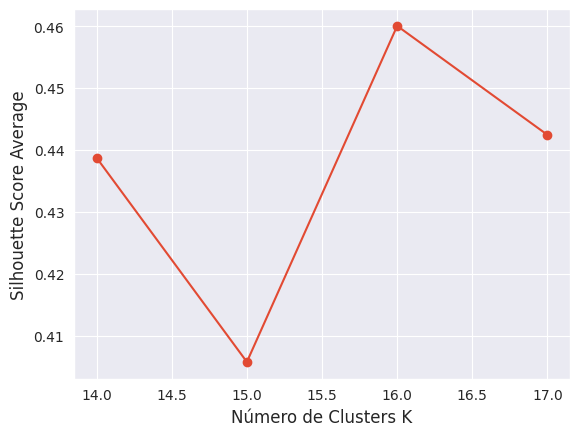

In [50]:
X_kmeans = X.loc[ :, ['brand', 'sub_category', 'type'] ]
    # >>> BEST - N.Cluster=16  Silhouette=0.826101


n_clusters = np.arange( 14, 18, 1 )
#n_clusters = [ 8 ]
best_ss = 0
best_k = 0
best_kmeans_model = None
first_time = True
ss_list = []

for c in n_clusters:
    # define model
    kmeans = ct.KMeans( 
        n_clusters=c, 
        init='random', 
        n_init=10, 
        random_state=0
    )

    # FIT & PREDICT
    labels = kmeans.fit_predict( X_kmeans )

    # performance (the bigger, the better)
    ss_avg = mt.silhouette_score( X_kmeans, labels)
    ss_list.append( ss_avg )

    # Compare result
    if first_time or ss_avg > best_ss:
        first_time = False
        best_ss = ss_avg
        best_k = c
        best_kmeans_model = kmeans
        print(">>> BEST - N.Cluster={}  Silhouette={:.6f}".format(best_k, best_ss))

    print( "n_clusters={}  - The Avg SS: {}".format( c, ss_avg ) )

print('---- BEST RESULT ---')
print("Number of Cluster={}  Silhouette={:.6f}".format(best_k, best_ss))

plt.plot( n_clusters, ss_list, marker='o' )
plt.xlabel( 'Número de Clusters K' )
plt.ylabel( 'Silhouette Score Average' )
print( best_kmeans_model )

# Monta a variável KMEANS e inclui em X
X['kmeans'] = best_kmeans_model.labels_

#INCLUI EM X_train e X_val
X_kmeans_train = X_train.loc[ :, ['brand', 'sub_category', 'type' ]]
X_train['kmeans'] = best_kmeans_model.predict( X_kmeans_train )

X_kmeans_val = X_val.loc[ :, ['brand', 'sub_category', 'type' ]]
X_val['kmeans'] = best_kmeans_model.predict( X_kmeans_val )

## 4.4 Transformação em Log

<Axes: xlabel='actual_price', ylabel='Count'>

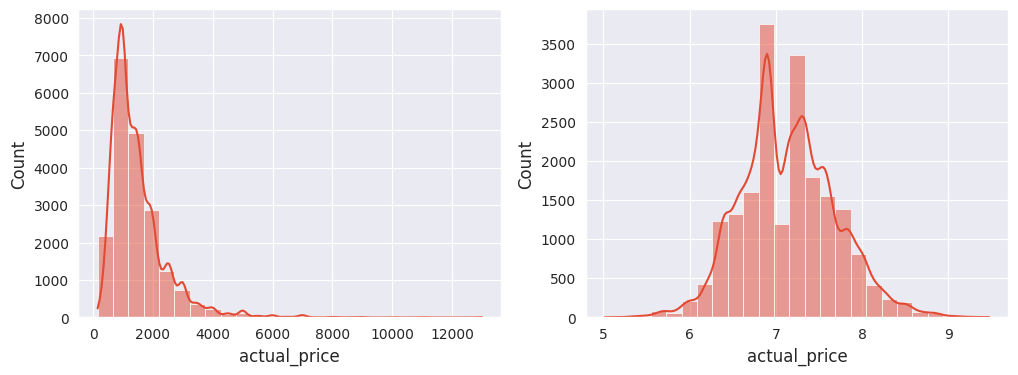

In [51]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(df1['actual_price'], kde=True, bins=25)

plt.subplot(1,2,2)
sns.histplot(np.log1p(df1['actual_price']), kde=True, bins=25)

In [52]:
#normalizar y
y = np.log1p( y )
y_train = np.log1p( y_train )
y_val = np.log1p( y_val )

## 4.5 Feature Importance

In [53]:
#Juntar X_train e X_val normalizados
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

In [54]:
X_full.shape

(19813, 44)

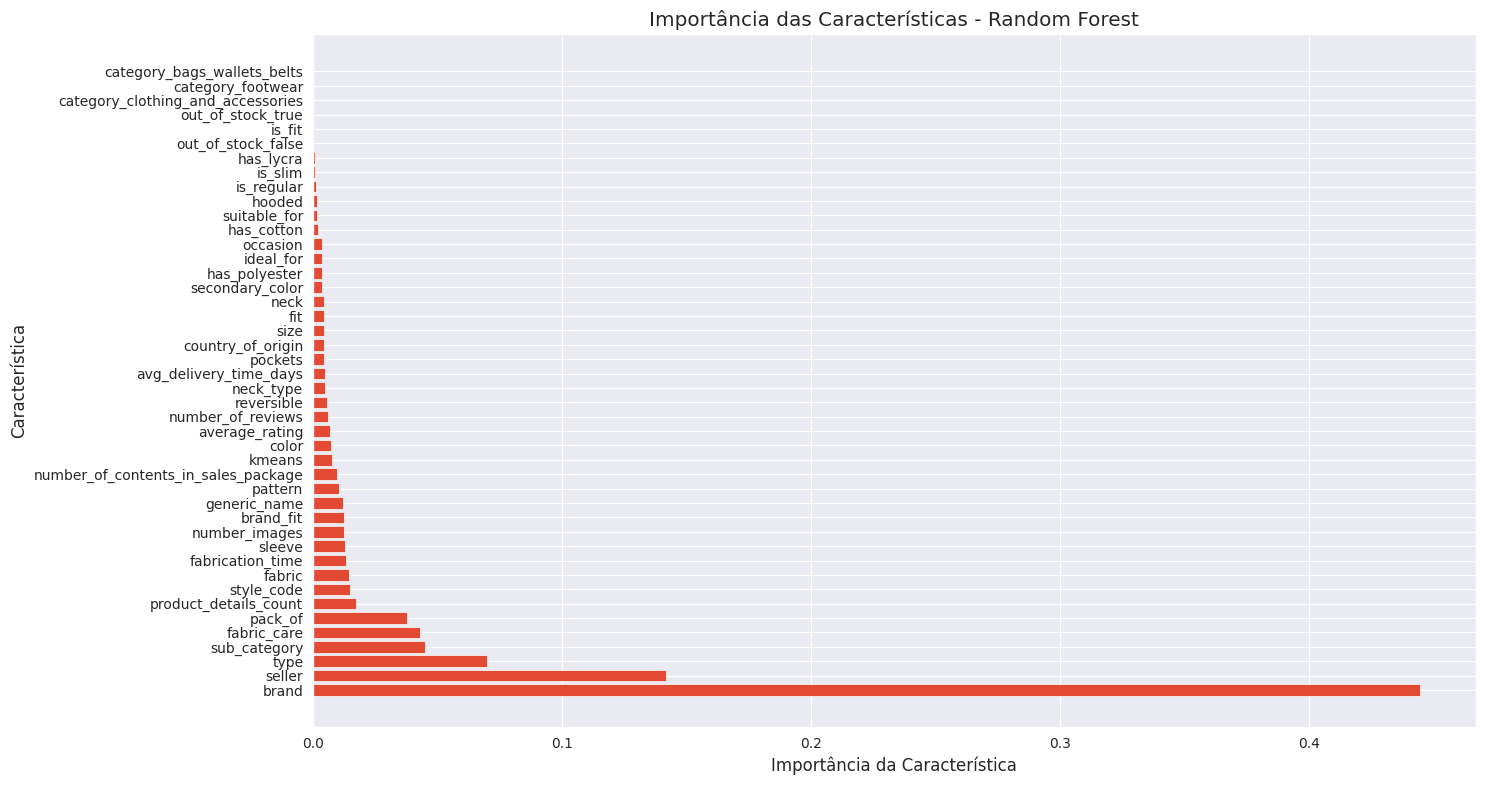

In [55]:
#<odelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1) 

#Treinamento
rf.fit(X_full, y_full)

#Obtenha a importância das características
feature_importance = rf.feature_importances_

#DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({'Feature': X_full.columns, 'Importance': feature_importance})

#Características com base na importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#Gráfico de barras
plt.figure(figsize=(15, 9))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importância da Característica')
plt.ylabel('Característica')
plt.title('Importância das Características - Random Forest')
plt.show()

<a name='5'></a>
# 5.0 Machine Learning

## Regressão Linear

In [56]:
#Instaciar modelo
lr = LinearRegression()

#FIT PREDICT
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

In [57]:
lr_metrics = compute_metrics('LinearRegression', y_pred_lr, y_val)

## XGBoost

In [58]:
#Instaciar modelo
xgb = XGBRegressor()

#FIT PREDICT
xgb.fit(X_train, y_train)
y_pred_val = xgb.predict(X_val)

In [59]:
xgb_metrics = compute_metrics('XGBoost', y_pred_val, y_val)

## Catboost

In [60]:
#Instaciar modelo
cat = CatBoostRegressor(verbose=False)

#FIT PREDICT
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_val)

In [61]:
cat_metrics = compute_metrics('CatBoost',y_pred_cat, y_val)

## LightGBM

In [62]:
#Instaciar modelo
lgb = LGBMRegressor()

#FIT PREDICT
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3084
[LightGBM] [Info] Number of data points in the train set: 15850, number of used features: 43
[LightGBM] [Info] Start training from score 7.138322


In [63]:
lgb_metrics = compute_metrics('LightGBM',y_pred_lgb, y_val)

## Random Forest

In [64]:
#Instaciar modelo
rf = RandomForestRegressor(n_jobs=-1, random_state=58)

#FIT PREDICT
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

In [65]:
rf_metrics = compute_metrics('RandomForest',y_pred_rf, y_val)

## Ensemble

In [66]:
#Instaciar modelo
voting_reg = VotingRegressor(
    estimators=[
        ('random_forest', rf),
        ('catboost', cat),
        ('xgboost', xgb),
        ('lighgbm', lgb),
        
    ]
)

#FIT PREDICT
voting_reg.fit(X_train, y_train)
y_pred_vot = voting_reg.predict(X_val)

#Calcular Metricas
ensenble_metrics = compute_metrics('VotingRegressor', y_pred_vot, y_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3084
[LightGBM] [Info] Number of data points in the train set: 15850, number of used features: 43
[LightGBM] [Info] Start training from score 7.138322


### Metrics

In [67]:
#Juntar todas as metricas
pd.concat([xgb_metrics, lgb_metrics, cat_metrics, rf_metrics, ensenble_metrics, lr_metrics]).sort_values(by='SMAPE').reset_index(drop=True)

,Model,MAE,MAPE,RMSE,SMAPE
0,RandomForest,169.302261,0.107761,388.639518,10.272758
1,VotingRegressor,192.396357,0.126434,381.441280,12.159259
2,XGBoost,202.098940,0.134544,399.446632,12.922436
3,CatBoost,210.754337,0.140210,382.726607,13.497201
4,LightGBM,217.019265,0.145070,407.767040,13.895672
5,LinearRegression,348.071286,0.231499,990.114375,22.272212


In [68]:
#Parametros usados na random forest
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 58,
 'verbose': 0,
 'warm_start': False}

## 5.1 Fine Tuning 

In [97]:
#Definir função objetivo do Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 25, 1000, 25),
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        
    }
    #Random Forest com os parâmetros otimizados
    model = RandomForestRegressor(**params, n_jobs=-1, random_state=58)

    #FIT PREDICT
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    #SMAPE
    smape_error = smape(np.expm1(y_pred), np.expm1(y_val))
    
    return smape_error

In [98]:
study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=50)

[I 2023-11-19 12:15:34,687] A new study created in memory with name: no-name-0b8f73ba-c99a-4dbd-a4cd-f1f91a2cfc3b
[I 2023-11-19 12:15:55,109] Trial 0 finished with value: 10.290960727591836 and parameters: {'n_estimators': 575}. Best is trial 0 with value: 10.290960727591836.
[I 2023-11-19 12:16:09,908] Trial 1 finished with value: 10.26764880225115 and parameters: {'n_estimators': 425}. Best is trial 1 with value: 10.26764880225115.
[I 2023-11-19 12:16:37,979] Trial 2 finished with value: 10.276270545225513 and parameters: {'n_estimators': 800}. Best is trial 1 with value: 10.26764880225115.
[I 2023-11-19 12:16:49,934] Trial 3 finished with value: 10.276290370939568 and parameters: {'n_estimators': 350}. Best is trial 1 with value: 10.26764880225115.
[I 2023-11-19 12:17:05,992] Trial 4 finished with value: 10.277774809755465 and parameters: {'n_estimators': 475}. Best is trial 1 with value: 10.26764880225115.
[I 2023-11-19 12:17:21,598] Trial 5 finished with value: 10.271163710857035 

In [99]:
#Melhores Parametros
optuna_best = study.best_params
optuna_best

{'n_estimators': 325}

In [100]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(template='plotly_dark', title='<b>Slice Plot', title_x=0.2)

In [101]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(template='plotly_dark', title='<b>Optimization History Plot', title_x=0.5)

In [102]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(template='plotly_dark', title='<b>Hyperparameter Importances', title_x=0.5)

<a name='6'></a>
# 6.0 Previsão Teste

In [105]:
#Ler teste
X_test_2 = pd.read_json( 'test.json', orient='split')

In [106]:
#Limpar teste
X_test_2 = clean_test(X_test_2)

In [107]:
# Inclui KMEANS em X_test_2
X_kmeans2 = X_test_2.loc[ :, ['brand', 'sub_category', 'type'] ]
X_test_2['kmeans'] = best_kmeans_model.predict( X_kmeans2 )

In [108]:
#PREDITC
y_pred_test = rf.predict(X_test_2)
y_pred_test = np.expm1(y_pred_test)

## Submission

In [109]:
df_submission = make_submission(X_test_2, y_pred_test)

In [110]:
df_submission.to_csv('submission_hackday_6_pt2.csv', index=False)

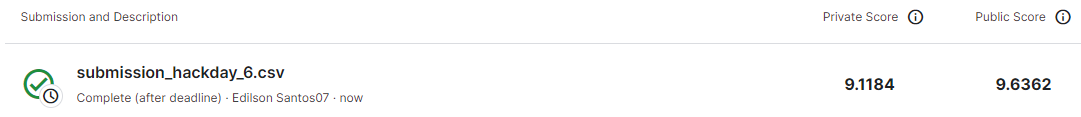

In [111]:
from IPython.display import Image
Image(filename='resultado.png')